In [6]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
from sklearn.linear_model import LinearRegression as lr
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf

In [7]:
pharma_tickers= [
"ATNM","AMPE",'RCUS',"PHGE","BMY","YCBD","CPHI","RDY","ELAN","LLY","EBS","GSK","IBIO","JNJ","MRK","MRNA","NNVC","NBY","NVS","NUVB","OGEN","PTN","PRGO","PFE","TAK","TEVA","TOVX","BHC","ZOM"]

tickerObjects = [yf.Ticker(i) for i in pharma_tickers]




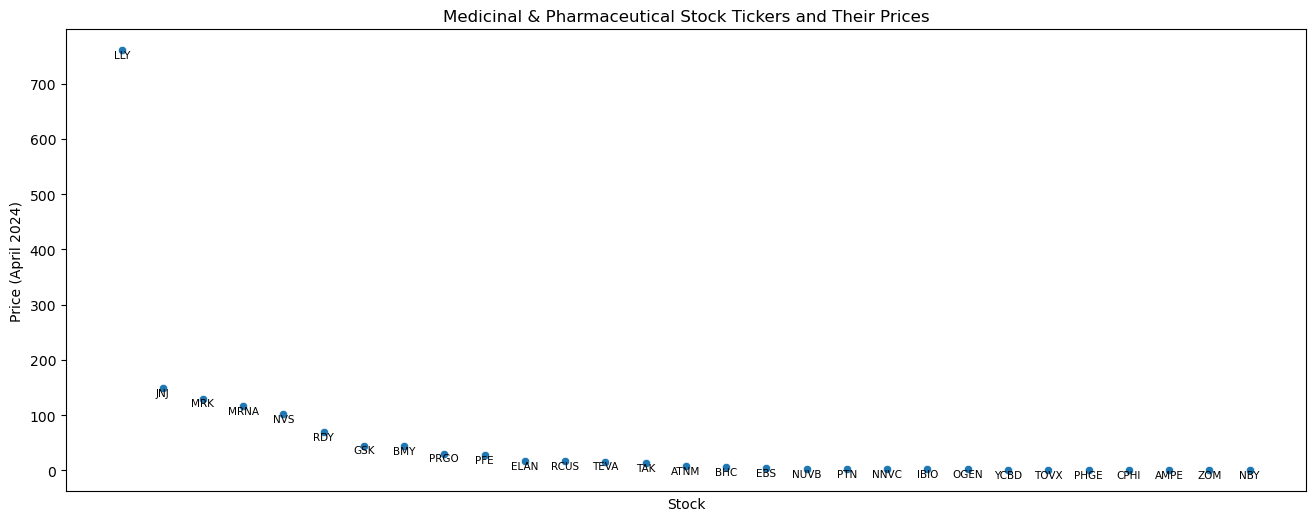

In [8]:

prices = []
for symbol in tickerObjects:
    
    prices.append(symbol.history(period='1d')['Close'][0])
df = pd.DataFrame({'stock': pharma_tickers, 'currentPrice': prices}).sort_values("currentPrice", ascending = False)
plt.figure(figsize=(16,6))
sns.scatterplot(data = df, x="stock", y="currentPrice")
plt.xlabel('Stock')
plt.xticks([])
for i in range(len(df)):
    plt.text(df["stock"].iloc[i],df["currentPrice"].iloc[i], str(df["stock"].iloc[i]), ha="center", va="top", fontsize= 7.5)
plt.tick_params(axis="x", labelsize=5, rotation = 45)
plt.title("Medicinal & Pharmaceutical Stock Tickers and Their Prices")
plt.ylabel("Price (April 2024)")
plt.show()

In [9]:
def priceAndDate(ticker, date):
    date = dt.strptime(date, '%Y-%m-%d')
    start_date = date - timedelta(days = 150)
    end_date = date + timedelta(days= 150)
    history_chunks=[]
    dates = []
    tickerObj = yf.Ticker(ticker)
    while start_date < end_date:
        # Calculate the end of the current week
        end_of_week = start_date + timedelta(days=6)
        
        # Fetch stock history for the current week
        stockInfoDf= tickerObj.history(start= start_date, end= end_date, interval="1d")
        avgPriceWeekly = stockInfoDf["Close"].mean()
        
        # Append the price avg to the list
        history_chunks.append(avgPriceWeekly)
        dates.append(start_date)
        # Move to the start of the next week
        start_date = end_of_week + timedelta(days=1)
    
    frame = pd.DataFrame({"Date": dates, "WeekAvgPrice":history_chunks}, index=[ticker]*len(dates))
    frame["AfterDate"] = (frame["Date"] > date).astype(int)
    return frame



In [10]:
#type(stockTickers) == List
#type(treatmentStock) == String (an element in stockTickers)
#date of format "Year-Mo-Dy"

def diffsRegression(stockTickers, treatmentStock, date):
    #concat DFs from each ticker
    frames= [priceAndDate(ticker,date) for ticker in stockTickers]
    data = pd.concat(frames)
    
    #set treatment indicator
    data['Treatment'] = (data.index.get_level_values(0) == treatmentStock).astype(int)
    
    # Interaction term: Treatment * AfterDate
    data['TreatmentxAfter'] = data['Treatment'] * data['AfterDate']
    
    # Setting up the regression model
    model = smf.ols('((WeekAvgPrice)) ~ Treatment + AfterDate + TreatmentxAfter', data=data).fit()
    yPred = model.predict(data)
    residuals = data["WeekAvgPrice"] - yPred
    
    # Printing the regression results and graphs
    print(model.summary())
    
    #Residuals scatterplot
    plt.figure(figsize=(4,5))
    plt.title("Residuals Plot")
    plt.axhline(y=0, color='red', linestyle='--')
    sns.scatterplot(data = data, x=yPred, y=residuals, hue=data.index )
    plt.figure(figsize = (6.3,5))

    #lineplot of prices of the stock 
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=data['Date'], y=data['WeekAvgPrice'], hue=data.index, linestyle="-")
    plt.title("Line Plot of WeekAvgPrice over Time")
    plt.grid(True)
    plt.show()

    
    #QQ Plot
    sm.qqplot(residuals, line ='45', fit=True)
    plt.title('QQ plot of Residuals')
    plt.show()
    

                            OLS Regression Results                            
Dep. Variable:           WeekAvgPrice   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     67.10
Date:                Sat, 11 May 2024   Prob (F-statistic):           1.66e-30
Time:                        02:16:12   Log-Likelihood:                -684.27
No. Observations:                 215   AIC:                             1377.
Df Residuals:                     211   BIC:                             1390.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          29.1515      0.628     

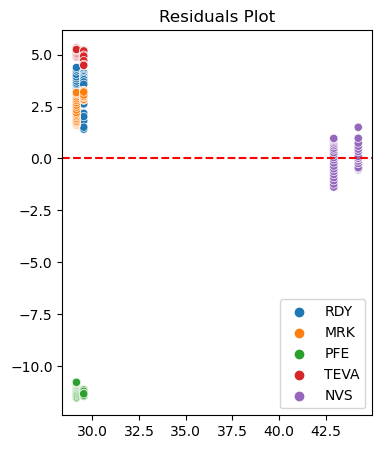

<Figure size 630x500 with 0 Axes>

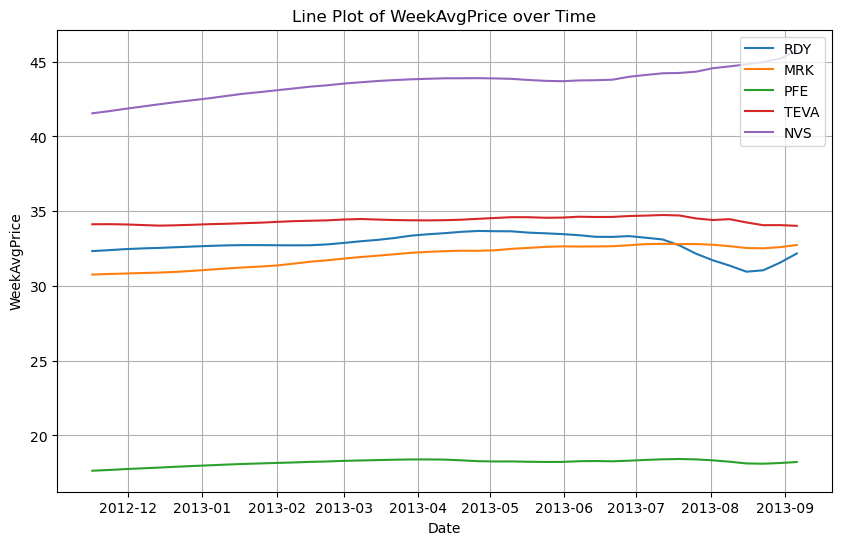

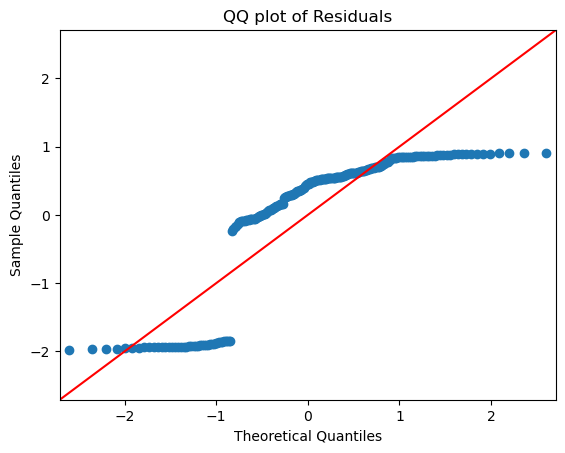

In [14]:
diffsRegression(["RDY", "MRK", "PFE","TEVA","NVS"], "NVS", "2013-04-15")